In [44]:
import torch
from ppo_learn_cartpole_with_hyperplanes_actor import Agent
from gymnasium.envs.registration import register
from envs.cartpole_pret_gymnasium_hyperparamactions import CartPoleEnvParamActions
import gymnasium as gym
import numpy as np

register(
    id="customEnvs/CartPoleEnvParamActions",
    entry_point="envs.cartpole_pret_gymnasium_hyperparamactions:CartPoleEnvParamActions",
)
#RL-DH/envs/cartpole_pret_gymnasium.py

def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        env = gym.wrappers.NormalizeReward(env, gamma=gamma)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
        return env

    return thunk


# Load the model's state_dict (parameters)
model_path = '/home/artur/Schreibtisch/DiscriminatingHyperplaneFork/discriminating-hyperplane/RL-DH/runs/customEnvs/CartPoleEnvParamActions__ppo_learn_cartpole_with_hyperplanes_actor__1__1731945866/ppo_learn_cartpole_with_hyperplanes_actor2.0.cleanrl_model'
envs = gym.vector.SyncVectorEnv([make_env("customEnvs/CartPoleEnvParamActions", 0, False, "Test", 0.99)])
agent = Agent(envs).to("cuda:0")
agent.load_state_dict(torch.load(model_path, map_location="cuda:0"))
agent.eval()

/tmp/ipykernel_100389/1600115783.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(model_path, map_location="cuda:0"))


Agent(
  (critic): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [45]:
obs = torch.Tensor([[1,0,0.4,0]]).to("cuda:0")
actions, _,_,_= agent.get_action_and_value(obs)
actions = actions.detach().cpu().numpy()
print(actions)

[[ 0.9930766 -1.5472159]]


-3.5999999999999996
-0.6283185307179586
-3.5999999999999996
-0.4886921905584123
-3.5999999999999996
-0.34906585039886595
-3.5999999999999996
-0.20943951023931962
-3.5999999999999996
-0.06981317007977328
-3.5999999999999996
0.06981317007977306
-3.5999999999999996
0.2094395102393194
-3.5999999999999996
0.34906585039886573
-3.5999999999999996
0.48869219055841207
-3.1999999999999997
-0.6283185307179586
-3.1999999999999997
-0.4886921905584123
-3.1999999999999997
-0.34906585039886595
-3.1999999999999997
-0.20943951023931962
-3.1999999999999997
-0.06981317007977328
-3.1999999999999997
0.06981317007977306
-3.1999999999999997
0.2094395102393194
-3.1999999999999997
0.34906585039886573
-3.1999999999999997
0.48869219055841207
-2.8
-0.6283185307179586
-2.8
-0.4886921905584123
-2.8
-0.34906585039886595
-2.8
-0.20943951023931962
-2.8
-0.06981317007977328
-2.8
0.06981317007977306
-2.8
0.2094395102393194
-2.8
0.34906585039886573
-2.8
0.48869219055841207
-2.4
-0.6283185307179586
-2.4
-0.4886921905584123

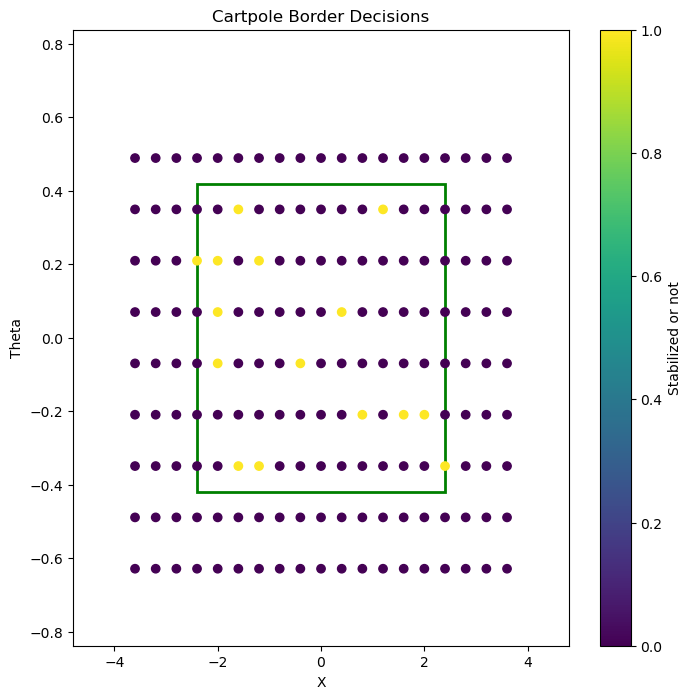

In [46]:
# initialize network
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        options =  {"state": np.array([x,0,theta,0])}
        o , info = envs.reset(options = options)
        o = torch.tensor(o, dtype=torch.float32)
        steps = 0
        done = False
        while not done and steps <=20:
            a, _,_,_= agent.get_action_and_value(obs)
            a = a.detach().cpu().numpy()
            a = a.reshape(1,-1)
            next_o, r, d,terminated, info = envs.step(a)
            done = d or terminated
            steps +=1
            o = next_o
            o = torch.tensor(o, dtype=torch.float32)
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues

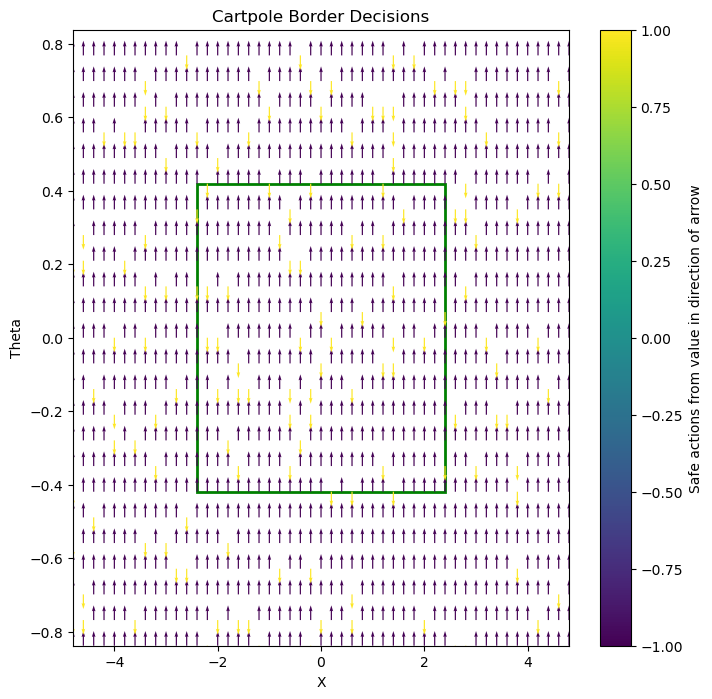

In [47]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=torch.tensor([[x,0,theta,0]], dtype=torch.float32)
        a, _,_,_= agent.get_action_and_value(obs)
        a_h,b_h = a[0]
        borders.append([x,theta])
        a_h = a_h.detach().cpu().numpy()
        b_h = b_h.detach().cpu().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()